# Random Forest Supervised Models

Running Machine Learning algorithms on generated networks.

Paper: A. Elliott, M. Cucuringu, M. M. Luaces, P. Reidy, and G. Reinert, Anomaly detection in networks with application to financial transaction networks, 2019

Based on the open source: https://github.com/zhangcheng1006/Anomaly-Detection-in-Networks

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from inspect import signature

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow import keras
import pickle

from utils import *

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### Load dataset and split for Random Forest
We mix all rows (each row represents a feature vector of a node) of all networks together by setting ```mix_all=True```, and then split them.

Load generated graph data from local files. This files are the node attribute values of some artificial networks. Attributes are the features recommended in the article.

In [3]:
data_path = './data_small_graph/'

combined_directed_G = load_networkx_graphs(data_path)
X_train, Y_train, _ = retrieve_node_features_and_labels_tuple(combined_directed_G)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

1000_Network_p_0.002_w_0.003.json  - max_node_id= -1
1000_Network_p_0.002_w_0.008.json  - max_node_id= 999
1000_Network_p_0.002_w_0.009.json  - max_node_id= 1999
1000_Network_p_0.004_w_0.004.json  - max_node_id= 2999
1000_Network_p_0.004_w_0.007.json  - max_node_id= 3999
1000_Network_p_0.004_w_0.009.json  - max_node_id= 4999
1000_Network_p_0.005_w_0.009.json  - max_node_id= 5999
1000_Network_p_0.006_w_0.007.json  - max_node_id= 6999
1000_Network_p_0.007_w_0.002.json  - max_node_id= 7999
1000_Network_p_0.007_w_0.009.json  - max_node_id= 8999
1000_Network_p_0.007_w_0.010.json  - max_node_id= 9999
1000_Network_p_0.008_w_0.000.json  - max_node_id= 10999
1000_Network_p_0.008_w_0.005.json  - max_node_id= 11999
1000_Network_p_0.008_w_0.007.json  - max_node_id= 12999
1000_Network_p_0.010_w_0.001.json  - max_node_id= 13999
1000_Network_p_0.010_w_0.006.json  - max_node_id= 14999
1000_Network_p_0.011_w_0.003.json  - max_node_id= 15999
1000_Network_p_0.011_w_0.005.json  - max_node_id= 16999
1000_N

In [4]:
X_train.shape, X_val.shape, X_test.shape

((28160, 129), (8800, 129), (7040, 129))

## 1. Unweighted RF model (not considering imbalanced labels)

In [5]:
print("n_est \t average precision")
for n_estimators in [10, 20, 50, 100, 150, 200, 250, 300, 400, 500]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1)
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_val)[:, 1]
    avg_prec = average_precision(pred_rf, Y_val)
    print(n_estimators, '\t', avg_prec)

n_est 	 average precision
10 	 0.6006698320367064
20 	 0.6338683877323449
50 	 0.6540020924641707
100 	 0.6590748955136254
150 	 0.6606050239285481
200 	 0.6620567843244424
250 	 0.6606483908059438
300 	 0.6636061333533582
400 	 0.6630709164368962
500 	 0.6650180383147156


__Discussion (choosing a model):__

By running a cross-validation, we find that ```n_estimators=100``` gives the best performance. We will choose this as the default model for the following work.

Predicition, Calculate precision, recall, F1-score

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1)
unweighted_history = rf.fit(X_train, Y_train)

train_predictions_baseline = rf.predict(X_train)
test_predictions_baseline = rf.predict(X_test)
    
fp, tp, _ = sklearn.metrics.roc_curve(Y_test, test_predictions_baseline)
auc_score = auc(fp, tp)
print(auc_score)

print(confusion_matrix(Y_test, test_predictions_baseline))
print(classification_report(Y_test, test_predictions_baseline))

0.6990358126721763
[[5980   92]
 [ 568  400]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      6072
           1       0.81      0.41      0.55       968

    accuracy                           0.91      7040
   macro avg       0.86      0.70      0.75      7040
weighted avg       0.90      0.91      0.89      7040



Legitimate Transactions Detected (True Negatives):  5980
Legitimate Transactions Incorrectly Detected (False Positives):  92
Fraudulent Transactions Missed (False Negatives):  568
Fraudulent Transactions Detected (True Positives):  400
Total Fraudulent Transactions:  968


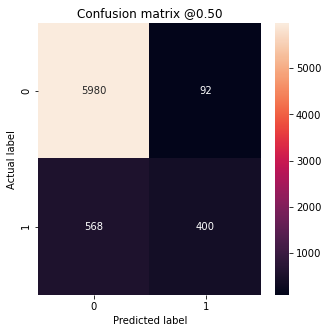

In [8]:
plot_cm(Y_test, test_predictions_baseline)

### Save the unweighted model & test the saved model

In [9]:
# save the model to disk
filename = 'models/randomforest/rf_no_weight_highprecision_lowrecall_model.pkl'
pickle.dump(rf, open(filename, 'wb'))

## 2. Weighted Model 1 (balancing the labels using parameter class_weight='balanced')

In [10]:
print("n_est \t average precision")
for n_estimators in [10, 20, 50, 100, 150, 200, 250, 300, 400, 500]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1, class_weight='balanced')
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_val)[:, 1]
    avg_prec = average_precision(pred_rf, Y_val)
    print(n_estimators, '\t', avg_prec)

n_est 	 average precision
10 	 0.6095524240075461
20 	 0.6308584322803397
50 	 0.6493463179964584
100 	 0.6522973589356895
150 	 0.6586411224397941
200 	 0.6599273855198269
250 	 0.660283444805376
300 	 0.660494589803033
400 	 0.6597753159011676
500 	 0.6616380860683287


In [10]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1, class_weight='balanced')
rf.fit(X_train, Y_train)

train_predictions_baseline2 = rf.predict(X_train)
test_predictions_baseline2 = rf.predict(X_test)

fp, tp, _ = sklearn.metrics.roc_curve(Y_test, test_predictions_baseline2)
auc_score = auc(fp, tp)
print(auc_score)

print(confusion_matrix(Y_test,test_predictions_baseline2))
print(classification_report(Y_test,test_predictions_baseline2))

0.6746316924182536
[[5991   81]
 [ 617  351]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      6072
           1       0.81      0.36      0.50       968

    accuracy                           0.90      7040
   macro avg       0.86      0.67      0.72      7040
weighted avg       0.89      0.90      0.88      7040



Legitimate Transactions Detected (True Negatives):  5991
Legitimate Transactions Incorrectly Detected (False Positives):  81
Fraudulent Transactions Missed (False Negatives):  617
Fraudulent Transactions Detected (True Positives):  351
Total Fraudulent Transactions:  968


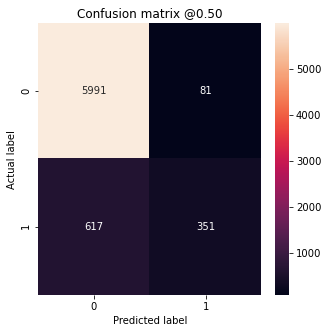

In [11]:
plot_cm(Y_test, test_predictions_baseline2)

## 3. Weighted Model 2 (using "BalancedRandomForestClassifier" class)

In [14]:
# generate dataset
# define model
print("n_est \t average precision")
for n_estimators in [10, 20, 50, 100, 150, 200, 300, 400, 500]:
    rf = BalancedRandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1)
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_val)[:, 1]
    avg_prec = average_precision(pred_rf, Y_val)
    print(n_estimators, '\t', avg_prec)


n_est 	 average precision
10 	 0.5457915761488223
20 	 0.608758904581229
50 	 0.6362987009472227
100 	 0.6394102757904464
150 	 0.6467345863399371
200 	 0.6444253197951122
300 	 0.6478661259519449
400 	 0.6498833390578128
500 	 0.6514207384178501


In [12]:
METRICS = ['accuracy', 'precision', 'recall', 'roc_auc']

rf = BalancedRandomForestClassifier(n_estimators=100)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_validate(rf, X_test, Y_test, scoring=METRICS, cv=cv, n_jobs=-1)

rf.fit(X_train, Y_train)

train_predictions_baseline3 = rf.predict(X_train)
test_predictions_baseline3 = rf.predict(X_test)

fp, tp, _ = sklearn.metrics.roc_curve(Y_test, test_predictions_baseline3)
auc_score = auc(fp, tp)
print(auc_score)

print(confusion_matrix(Y_test,test_predictions_baseline3))
print(classification_report(Y_test,test_predictions_baseline3))

0.7657728470475507
[[5009 1063]
 [ 284  684]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      6072
           1       0.39      0.71      0.50       968

    accuracy                           0.81      7040
   macro avg       0.67      0.77      0.69      7040
weighted avg       0.87      0.81      0.83      7040



Legitimate Transactions Detected (True Negatives):  5009
Legitimate Transactions Incorrectly Detected (False Positives):  1063
Fraudulent Transactions Missed (False Negatives):  284
Fraudulent Transactions Detected (True Positives):  684
Total Fraudulent Transactions:  968


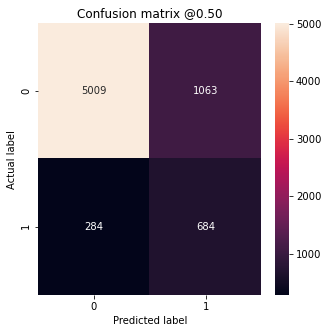

In [13]:
plot_cm(Y_test, test_predictions_baseline3)

### Save the best weighted model & test the saved model

In [14]:
# Save model
filename2 = 'models/randomforest/rf_weighted_lowprecision_highrecall_model.pkl'
pickle.dump(rf, open(filename2, 'wb'))

In [17]:
# load the model from disk
rf_model2 = pickle.load(open(filename2, 'rb'))

In [18]:
train_predictions_baseline2 = rf_model2.predict(X_train)
test_predictions_baseline2 = rf_model2.predict(X_test)

fp, tp, _ = sklearn.metrics.roc_curve(Y_test, test_predictions_baseline2)
auc_score = auc(fp, tp)
print(auc_score)

print(confusion_matrix(Y_test,test_predictions_baseline2))
print(classification_report(Y_test,test_predictions_baseline2))

0.7735920518606524
[[4891 1153]
 [ 261  735]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      6044
           1       0.39      0.74      0.51       996

    accuracy                           0.80      7040
   macro avg       0.67      0.77      0.69      7040
weighted avg       0.87      0.80      0.82      7040



## Performance measurement

In [19]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  4891
Legitimate Transactions Incorrectly Detected (False Positives):  1153
Fraudulent Transactions Missed (False Negatives):  261
Fraudulent Transactions Detected (True Positives):  735
Total Fraudulent Transactions:  996


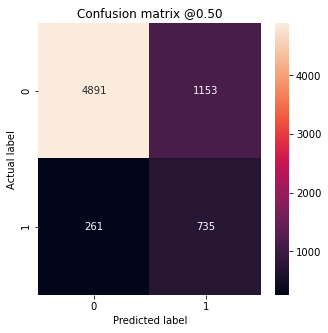

In [20]:
plot_cm(Y_test, test_predictions_baseline2)

In [15]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

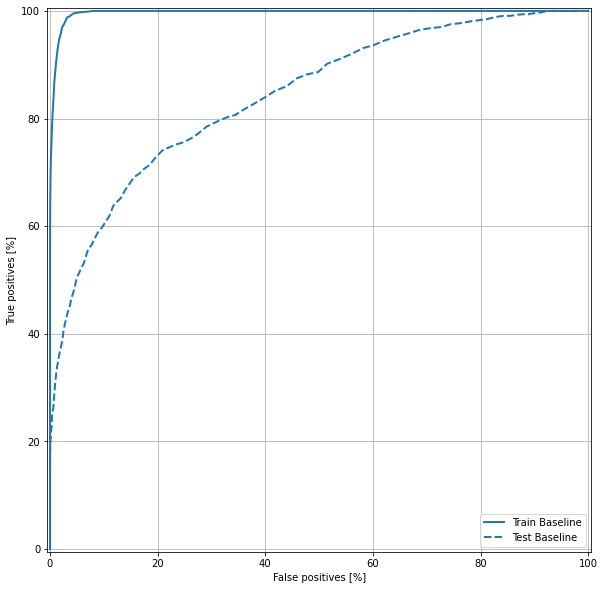

In [18]:
train_predictions_baseline = rf.predict_proba(X_train)[:, 1]
test_predictions_baseline = rf.predict_proba(X_test)[:, 1]

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [12]:
METRICS = ['accuracy', 'precision', 'recall', 'roc_auc']

# generate dataset
# define model
print("n_est \t average precision")
for n_estimators in [10, 20, 50, 100, 150, 200, 300, 400, 500]:
    rf = BalancedRandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1)
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_val)[:, 1]
    avg_prec = average_precision(pred_rf, Y_val)
    print(n_estimators, '\t', avg_prec)


n_est 	 average precision
10 	 0.5602517367652842
20 	 0.6673872552546067
50 	 0.7085642682900777
100 	 0.7054699713330098
150 	 0.7026802030973694
200 	 0.7144438560458134
300 	 0.709009551419483
400 	 0.7168782261160132
500 	 0.7197168261802868


In [13]:
rf = BalancedRandomForestClassifier(n_estimators=100)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_validate(rf, X_test, Y_test, scoring=METRICS, cv=cv, n_jobs=-1)
# summarize performance
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

rf.fit(X_train, Y_train)

Mean precision: 0.327
Mean recall: 0.768
Mean ROC AUC: 0.858


BalancedRandomForestClassifier()

### Feature selection

List all features

In [24]:
features = list(X_train.columns)
print(features)

['NetEMD_comb_1', 'NetEMD_comb_2', 'NetEMD_lower_1', 'NetEMD_lower_2', 'NetEMD_rw_1', 'NetEMD_rw_2', 'NetEMD_upper_1', 'NetEMD_upper_2', 'comb_abs90', 'comb_absolute_value', 'comb_exp_1', 'comb_exp_2', 'comb_exp_3', 'comb_exp_4', 'comb_ipr90', 'comb_ipr_1', 'comb_ipr_2', 'comb_ipr_3', 'comb_ipr_4', 'comb_sign_equal_1', 'comb_sign_equal_2', 'comb_sign_stat_1', 'comb_sign_stat_2', 'degree_std', 'first_density', 'first_strength', 'gaw10_score', 'gaw20_score', 'gaw_score', 'in_out_strength_1', 'in_out_strength_2', 'in_strength_1', 'in_strength_2', 'lower_abs90', 'lower_absolute_value', 'lower_exp_1', 'lower_exp_2', 'lower_exp_3', 'lower_exp_4', 'lower_ipr90', 'lower_ipr_1', 'lower_ipr_2', 'lower_ipr_3', 'lower_ipr_4', 'lower_sign_equal_1', 'lower_sign_equal_2', 'lower_sign_stat_1', 'lower_sign_stat_2', 'motif_10_1', 'motif_10_2', 'motif_11_1', 'motif_11_2', 'motif_12_1', 'motif_12_2', 'motif_13_1', 'motif_13_2', 'motif_14_1', 'motif_14_2', 'motif_15_1', 'motif_15_2', 'motif_16_1', 'motif_1

According to the way by which they are generated, 129 features are divided in 5 categories: Localise, NetEMD, Basic, Path, Community Density.

In [25]:
features_categories = {}
for cat, feats in categories_features.items():
    for feat in feats:
        features_categories[feat] = cat

In [52]:
len(categories_features.get("Localise"))

60

In [51]:
len(categories_features.get("NetEMD"))

40

In [52]:
len(categories_features.get("Basic"))

3

In [53]:
len(categories_features.get("Path"))

19

In [54]:
len(categories_features.get("Com. Density"))

7

In [61]:
len(features)

129

Random Forest can assign each feature an importance, we use this importance to sort features and select some most important ones.

In [26]:
feature_rank = sorted(zip(features, rf.feature_importances_), key=lambda x: x[1], reverse=True)
feature_rank

[('comb_absolute_value', 0.05322701641296065),
 ('rw_absolute_value', 0.0500025770594162),
 ('upper_absolute_value', 0.0473690839381116),
 ('NetEMD_lower_1', 0.047242453401738764),
 ('degree_std', 0.047040526745520214),
 ('first_density', 0.0469957270835421),
 ('gaw20_score', 0.04663139142879187),
 ('lower_absolute_value', 0.04644131964182028),
 ('gaw10_score', 0.046037558230147164),
 ('first_strength', 0.04316924827714339),
 ('second_density', 0.032902658071990755),
 ('second_strength', 0.03277225731723612),
 ('NetEMD_lower_2', 0.01874683755236708),
 ('third_density', 0.016965146890855088),
 ('path_11', 0.01634676196787512),
 ('path_10', 0.015774535295820086),
 ('path_9', 0.015435958680366743),
 ('path_12', 0.014940717493413833),
 ('gaw_score', 0.010970638652463262),
 ('path_8', 0.010512109243981134),
 ('path_2', 0.009980446662375318),
 ('NetEMD_rw_1', 0.009905523194440467),
 ('comb_sign_stat_2', 0.008777201163807586),
 ('comb_exp_4', 0.008271142449393807),
 ('upper_sign_stat_2', 0.00

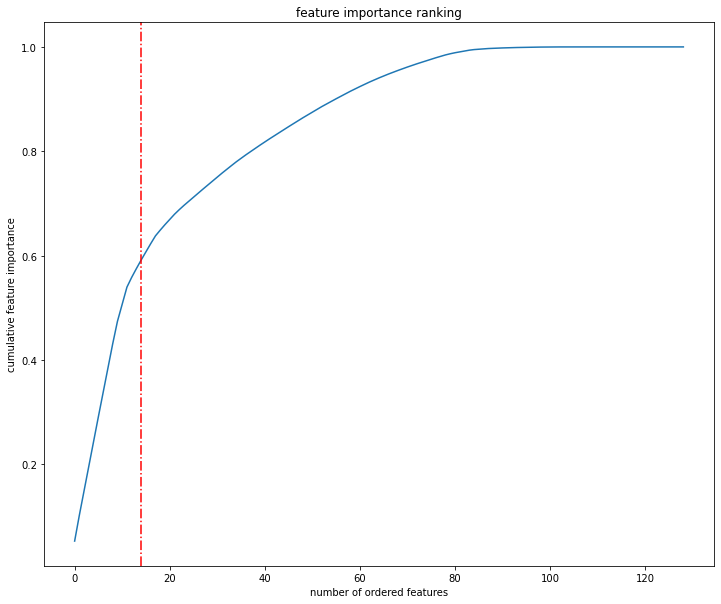

In [27]:
f_rank_cumsum = np.cumsum(np.array([x[1] for x in feature_rank]))
plt.plot(f_rank_cumsum)
plt.title("feature importance ranking")
plt.xlabel("number of ordered features")
plt.ylabel("cumulative feature importance")
plt.axvline(x=14, linestyle='-.', color='r')

The figure above shows that there is a obvious elbow at ```num_features = 14```. We will choose only the 14 first features for the next.

In [28]:
selected_features = [feat for feat, feat_imp in feature_rank[:14]]
print(selected_features)

['comb_absolute_value', 'rw_absolute_value', 'upper_absolute_value', 'NetEMD_lower_1', 'degree_std', 'first_density', 'gaw20_score', 'lower_absolute_value', 'gaw10_score', 'first_strength', 'second_density', 'second_strength', 'NetEMD_lower_2', 'third_density']


We look into the 14 selected features and see which category they belongs to.

In [29]:
selected_features_categories = [features_categories[feat] for feat in selected_features]

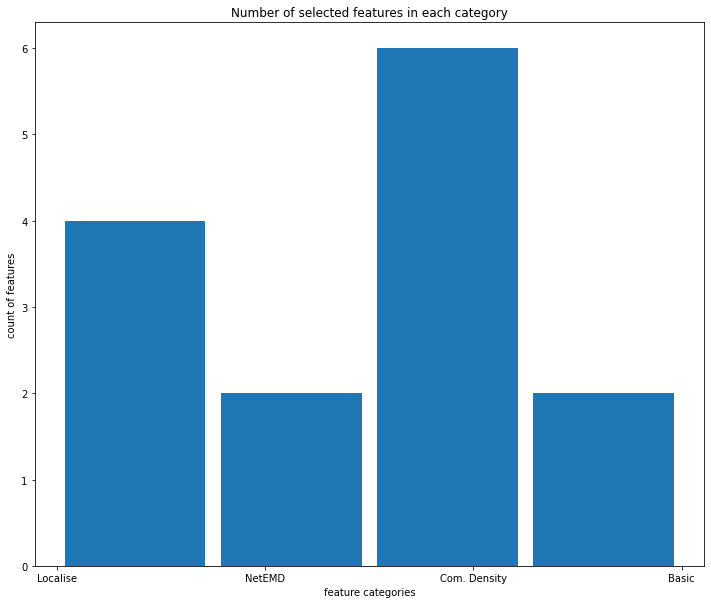

In [30]:
plt.figure()
plt.hist(selected_features_categories, bins=4, align='mid', rwidth=0.9)
plt.title("Number of selected features in each category")
plt.ylabel("count of features")
plt.xlabel("feature categories")
plt.show()

__Discussion__:

According to the figure above, we notice that The community detection category contributes most, while none path-based features are among the 14 most significant features.

### Train model on selected features

We then retrain the model on only the 14 selected features.

In [31]:
X_train = X_train.loc[:, selected_features]
X_val = X_val.loc[:, selected_features]
X_test = X_test.loc[:, selected_features]

In [32]:
X_train.shape, X_val.shape, X_test.shape

((9600, 14), (2400, 14), (3000, 14))

In [33]:
print("n_est \t avrage precision")
for n_estimators in [10, 20, 50, 100, 150, 200, 250, 300]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1)
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_test)[:, 1]
    avg_prec = average_precision(pred_rf, Y_test)
    print(n_estimators, '\t', avg_prec)

n_est 	 avrage precision
10 	 0.7073948103326522
20 	 0.7236031961193002
50 	 0.7297566099017042
100 	 0.7413192534700612
150 	 0.7406205179586014
200 	 0.7431628764409591
250 	 0.7421398628829523
300 	 0.7473697935114502


In [34]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1)
rf.fit(X_train, Y_train)

train_predictions_baseline2 = rf.predict(X_train)
test_predictions_baseline2 = rf.predict(X_test)

print(confusion_matrix(Y_test,test_predictions_baseline2))
print(classification_report(Y_test,test_predictions_baseline2))

[[2577   34]
 [ 190  199]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2611
           1       0.85      0.51      0.64       389

    accuracy                           0.93      3000
   macro avg       0.89      0.75      0.80      3000
weighted avg       0.92      0.93      0.92      3000



In [35]:
avg_prec = average_precision(pred_rf, Y_test)
avg_prec

0.7473697935114502

### Test on whole networks

Formerly, we mix all nodes of different networks together and split them for training and testing. In this section, we will try to train models on some networks and test them on some other networks. The testing networks are kept as a whole. Therefore, for each testing network, we perform the prediciton and evaluation precedure, and then average the performance metrics on all testing networks.

In [39]:
# select_features is no longer None, to use only the 14 seleceted features
# mix_all set to False
X_train, X_test, Y_train, Y_test = split_train_test(data, test_size=0.3, mix_all=False, select_features=selected_features)

C:\Users\ttr\Anaconda3\envs\july\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [40]:
X_train.shape, len(X_test)

((11000, 14), 4)

In [41]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=-1)

In [42]:
sample_sizes = [8, 16, 32, 64, 128, 256, 512]
performance_measures = ['precision', 'recall', 'f1-score', 'avg-precision']
network_index = sorted(list(range(len(X_test)))*len(sample_sizes))
performance_matrix = pd.DataFrame(columns=performance_measures, index=[network_index, sample_sizes*len(X_test)], dtype=float)
performance_matrix.index.names= ['network_id', 'sample_size']

for network_id, (network, labels) in enumerate(zip(X_test, Y_test)):
    pred = rf.predict_proba(network)[:, 1]
    avg_prec = average_precision(pred, labels)
    precs, recs, f1s = precision_recall(pred, labels, *sample_sizes)
    for sample_size, prec, rec, f1 in zip(sample_sizes, precs, recs, f1s):
        performance_matrix.loc[(network_id, sample_size), 'precision'] = prec
        performance_matrix.loc[(network_id, sample_size), 'recall'] = rec
        performance_matrix.loc[(network_id, sample_size), 'f1-score'] = f1
        performance_matrix.loc[(network_id, sample_size), 'avg-precision'] = avg_prec
performance_matrix

precision    recall  f1-score  avg-precision
network_id sample_size                                              
0          8             0.000000  0.000000  0.000000       0.177630
           16            0.187500  0.037500  0.062500       0.177630
           32            0.281250  0.112500  0.160714       0.177630
           64            0.281250  0.225000  0.250000       0.177630
           128           0.250000  0.400000  0.307692       0.177630
           256           0.164062  0.525000  0.250000       0.177630
           512           0.113281  0.725000  0.195946       0.177630
1          8             0.625000  0.031250  0.059524       0.236893
           16            0.687500  0.068750  0.125000       0.236893
           32            0.500000  0.100000  0.166667       0.236893
           64            0.328125  0.131250  0.187500       0.236893
           128           0.234375  0.187500  0.208333       0.236893
           256           0.203125  0.325000  0.250000       0.236893
           512           0.173828  0.556250  0.264881       0.236893
2          8             1.000000  0.036866  0.071111       0.463119
           16            1.000000  0.073733  0.137339       0.463119
           32            0.906250  0.133641  0.232932       0.463119
           64            0.609375  0.179724  0.277580       0.463119
           128           0.382812  0.225806  0.284058       0.463119
           256           0.367188  0.433180  0.397463       0.463119
           512           0.363281  0.857143  0.510288       0.463119
3          8             0.750000  0.065934  0.121212       0.223662
           16            0.562500  0.098901  0.168224       0.223662
           32            0.375000  0.131868  0.195122       0.223662
           64            0.250000  0.175824  0.206452       0.223662
           128           0.187500  0.263736  0.219178       0.223662
           256           0.156250  0.439560  0.230548       0.223662
           512           0.156250  0.879121  0.265340       0.223662

In [43]:
average_performance = performance_matrix.groupby('sample_size').mean()
std_performance = performance_matrix.groupby('sample_size').std()
average_performance

,precision,recall,f1-score,avg-precision
sample_size,,,,
8,0.593750,0.033513,0.062962,0.275326
16,0.609375,0.069721,0.123266,0.275326
32,0.515625,0.119502,0.188859,0.275326
64,0.367188,0.177949,0.230383,0.275326
128,0.263672,0.269261,0.254815,0.275326
256,0.222656,0.430685,0.282003,0.275326
512,0.201660,0.754378,0.309114,0.275326


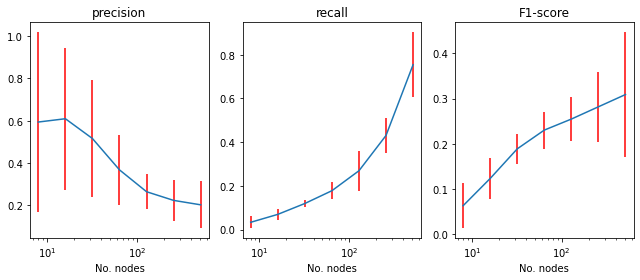

In [44]:
plt.figure(figsize=(9, 4))

plt.subplot(131)
plt.errorbar(sample_sizes, average_performance['precision'], yerr=std_performance['precision'], ecolor='r')
plt.xscale('log')
plt.title("precision")
plt.xlabel('No. nodes')

plt.subplot(132)
plt.errorbar(sample_sizes, average_performance['recall'], yerr=std_performance['recall'], ecolor='r')
plt.xscale('log')
plt.title("recall")
plt.xlabel('No. nodes')

plt.subplot(133)
plt.errorbar(sample_sizes, average_performance['f1-score'], yerr=std_performance['f1-score'], ecolor='r')
plt.xscale('log')
plt.title("F1-score")
plt.xlabel('No. nodes')

plt.tight_layout()